In [1]:
import sys
sys.path.append("../../../")

## 数据

In [2]:
from pylib.utils.functions_for_regression import bimodal_data, plot_scatter
import matplotlib.pyplot as plt

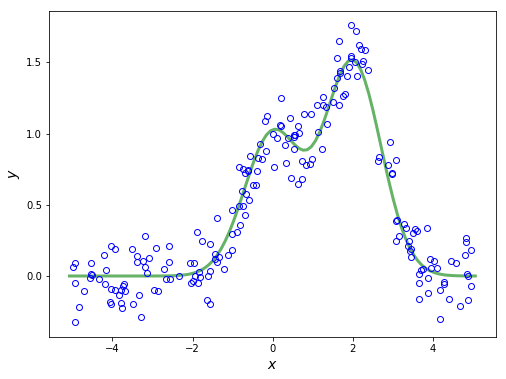

In [3]:
X_train, y_train, X_test, y_test, f_truth = bimodal_data(300)
plt.figure(figsize=(8, 6))
plot_scatter(X_train, y_train, f=f_truth)
plt.show()

## 立方样条

In [4]:
from pylib.utils.functions_for_regression import plot_fitted_line
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

In [5]:
class CubicSplineFeatures(BaseEstimator, TransformerMixin):
    """
    立方样条特征
    
    参数
    ----
    knots: 结点值列表
    dofs: 自由度。在立方样条中，这个值应该大于4
    """
    def __init__(self, knots=None, dofs=None):
        self.knots = [knots] if knots is not None else None
        self.dofs = dofs
        self.order = 4
        
    def fit(self, X, y=None):
        
        if self.dofs is not None:
            if self.dofs <= 4:
                  raise Exception("Please input a degree of freedom > 4")
            quantiles = np.linspace(0, 1, self.dofs - 4)
            self.knots = []
            for i in range(X.shape[1]):
                self.knots.append(np.unique(np.quantile(X[:, i], quantiles)).tolist())
        return self

    def transform(self, X):
        H = []
        knots = np.array(self.knots).ravel()
        for i in range(X.shape[1]):
            for j in range(self.order):
                H.append(X[:, i]**j)
            for k in knots:
                H.append(np.where((X[:, i] - k)**3 > 0, (X[:, i] - k)**3, 0))
        return np.array(H).T

In [6]:
knots = [-2, 0.1, 0.8, 2.1]
cs_pipeline = Pipeline([("cubic_spline", CubicSplineFeatures(knots=knots)),
                         ("scaler", StandardScaler()),
                         ("linreg", LinearRegression())])
cs_pipeline.fit(X_train, y_train)

Pipeline(steps=[('cubic_spline',
                 CubicSplineFeatures(knots=[[-2, 0.1, 0.8, 2.1]])),
                ('scaler', StandardScaler()), ('linreg', LinearRegression())])

In [7]:
y_pred = cs_pipeline.predict(X_train)
train_err = mean_squared_error(y_train, y_pred)
print("训练样本误差: {:.3f}".format(train_err)) # 均方差

训练样本误差: 0.028


In [8]:
y_pred = cs_pipeline.predict(X_test)
test_err = mean_squared_error(y_test, y_pred)
print("测试样本误差: {:.3f}".format(test_err))

测试样本误差: 0.039


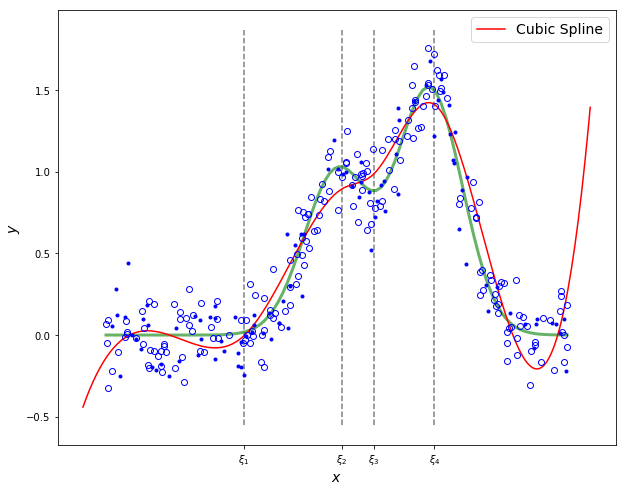

In [9]:
plt.figure(figsize=(10, 8))
plot_scatter(X_train, y_train, X_test, y_test, f=f_truth)
xn = np.linspace(plt.xlim()[0], plt.xlim()[1], 100).reshape(-1, 1)
yn_pred = cs_pipeline.predict(xn)
plot_fitted_line(cs_pipeline, "Cubic Spline")
ylim_min = plt.ylim()[0]
ylim_max = plt.ylim()[1]
for xi in knots:
    plt.vlines(xi, ylim_min, ylim_max, linestyles='--', colors='gray')
plt.xticks(knots, [r'$\xi_1$', r'$\xi_2$', r'$\xi_3$', r'$\xi_4$'])
plt.legend(fontsize=14)
plt.show()

### 寻找最优参数

In [10]:
from sklearn.model_selection import GridSearchCV

In [11]:
cs_pipeline = Pipeline([("cubic_spline", CubicSplineFeatures()),
                         ("scaler", StandardScaler()),
                         ("linreg", LinearRegression())])
param_grid = {"cubic_spline__dofs": np.arange(5, 31, 1)}
cs_cv = GridSearchCV(
    cs_pipeline,
    param_grid,
    scoring='neg_mean_squared_error',
    cv=10,
    n_jobs=-1
)
cs_cv.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('cubic_spline', CubicSplineFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('linreg', LinearRegression())]),
             n_jobs=-1,
             param_grid={'cubic_spline__dofs': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30])},
             scoring='neg_mean_squared_error')

In [12]:
print("最优自由度：{}".format(cs_cv.best_params_['cubic_spline__dofs']))

最优自由度：16


### 使用最优模型

In [13]:
cs_best = cs_cv.best_estimator_

In [14]:
y_pred = cs_best.predict(X_train)
train_err = mean_squared_error(y_train, y_pred)
print("训练样本误差: {:.3f}".format(train_err)) # 均方差

训练样本误差: 0.020


In [15]:
y_pred = cs_best.predict(X_test)
test_err = mean_squared_error(y_test, y_pred)
print("测试样本误差: {:.3f}".format(test_err))

测试样本误差: 0.028


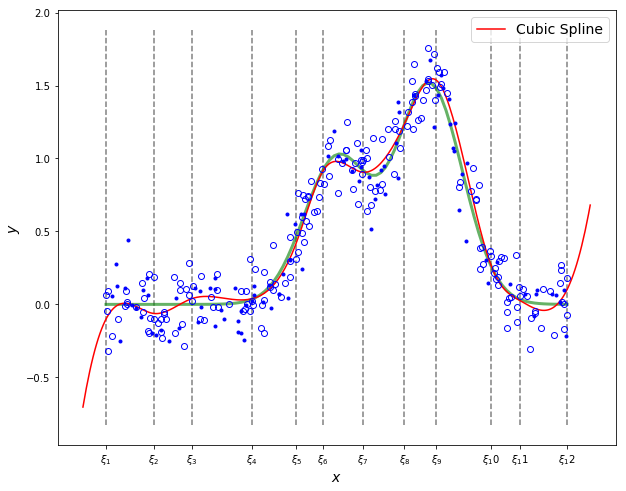

In [16]:
plt.figure(figsize=(10, 8))
plot_scatter(X_train, y_train, X_test, y_test, f=f_truth)
plot_fitted_line(cs_best, "Cubic Spline")
ylim_min = plt.ylim()[0]
ylim_max = plt.ylim()[1]
knots = cs_best.named_steps["cubic_spline"].knots[0]
labels = []
for i, xi in enumerate(knots):
    plt.vlines(xi, ylim_min, ylim_max, linestyles='--', colors='gray')
    labels.append(r'$\xi_{}$'.format(i + 1))
plt.xticks(knots, labels)
plt.legend(fontsize=14)
plt.show()

### 截断幂数基

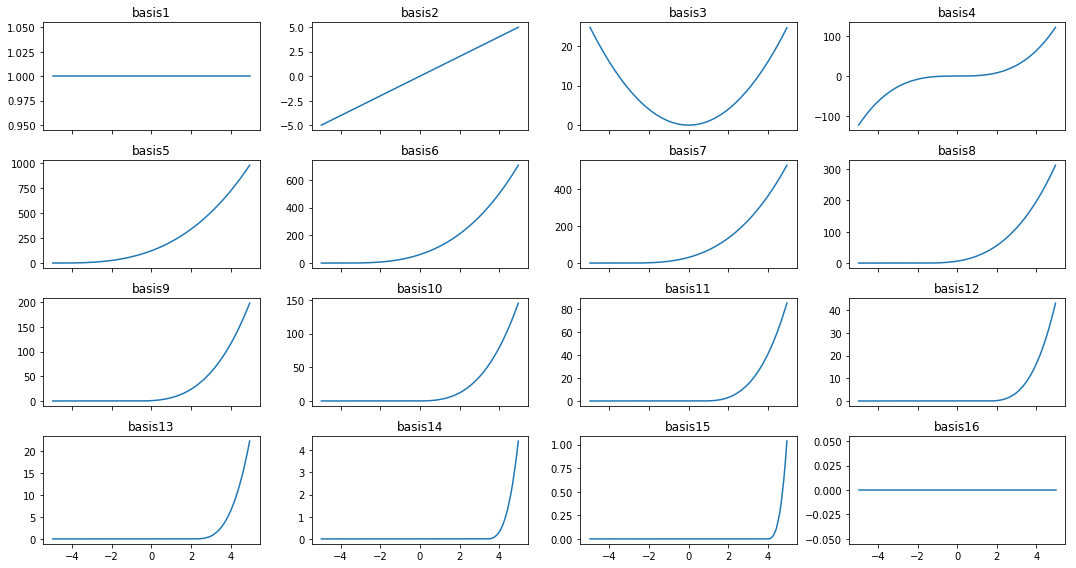

In [17]:
H = cs_best.named_steps["cubic_spline"].transform(X_train)
X_sort = np.sort(X_train.ravel())
H_sort = H[np.argsort(X_train.ravel())]

fig, axes = plt.subplots(4, 4, sharex=True, figsize=(15, 8))
axes = axes.flatten()
for i in range(H.shape[1]):
    axes[i].plot(X_sort, H_sort[:, i])
    axes[i].set_title("basis{}".format(i+1))
plt.tight_layout()
plt.show()